# Data Preparation

In [1]:
IMAGE_SIZE = 256
BATCH_SIZE = 128

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

# Paths to dataset
train_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
validation_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'
classes_dir = '/kaggle/input/plant-project-dataset/Project Data/Train/images'

def get_plant_name(plant_disease_name):
  return plant_disease_name.partition('___')[0]

class_names = [get_plant_name(x) for x in os.listdir(classes_dir)]
class_names = sorted(list(set(class_names)))
# print(class_names)

classes = []
folder_to_className = {}

for folder in os.listdir(train_dir):
    class_name = get_plant_name(folder)
    if class_name in class_names:
        folder_to_className[folder] = class_name
        classes.append(folder)
# print(classes)
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes = classes,
    shuffle=True, 
)
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator =validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    classes = classes,
)

# Remap class indices
new_class_indices = {v: i for i, v in enumerate(class_names)}
print("New class indices:", new_class_indices)

def remap_labels(generator, custom_mapping, new_classes):
    for batch_images, batch_labels in generator:
        # Find original class labels
        original_classes = {v: k for k, v in generator.class_indices.items()}

        # Map original classes to new classes
        mapped_labels = np.zeros((batch_labels.shape[0], len(new_classes)))
        for idx, label in enumerate(batch_labels):
            # Get original class name
            original_class = original_classes[np.argmax(label)]

            # Find new class name
            new_class_name = custom_mapping[original_class]
            new_class_index = new_classes[new_class_name]

            # Update label
            mapped_labels[idx, new_class_index] = 1

        yield batch_images, mapped_labels

# Use the remapped generator
remapped_train_generator = remap_labels(train_generator, folder_to_className, new_class_indices)
remapped_validation_generator = remap_labels(validation_generator, folder_to_className, new_class_indices)

Found 60930 images belonging to 33 classes.
Found 15231 images belonging to 33 classes.
New class indices: {'Apple': 0, 'Cherry_(including_sour)': 1, 'Corn_(maize)': 2, 'Grape': 3, 'Peach': 4, 'Pepper,_bell': 5, 'Potato': 6, 'Strawberry': 7, 'Tomato': 8}


# Visualizations

In [3]:
import matplotlib.pyplot as plt
def plot_samples_in_grid(generator, class_indices, num_classes, grid_shape, title):
    samples_per_class = {}
    for batch_images, batch_labels in generator:
        for i in range(batch_labels.shape[0]):
            label = np.argmax(batch_labels[i])
            if label not in samples_per_class:
                samples_per_class[label] = batch_images[i]
                if len(samples_per_class) == num_classes:
                    break
        if len(samples_per_class) == num_classes:
            break

    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=(10, 10))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for i, (class_index, image) in enumerate(samples_per_class.items()):
        axes[i].imshow(image)
        axes[i].axis('off')
        class_name = [name for name, index in class_indices.items() if index == class_index][0]
        axes[i].set_title(class_name, fontsize=10)
    for j in range(len(samples_per_class), len(axes)):
        axes[j].axis('off')  # Hide any extra subplots
    plt.tight_layout()
    plt.show()

## Train Samples

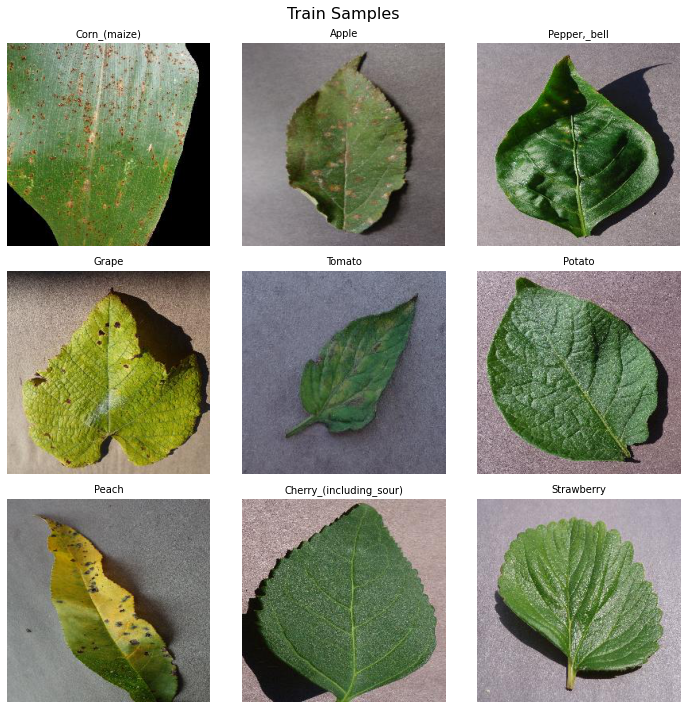

In [4]:
plot_samples_in_grid(remapped_train_generator, new_class_indices, 9, (3, 3), "Train Samples")

## Validation Samples

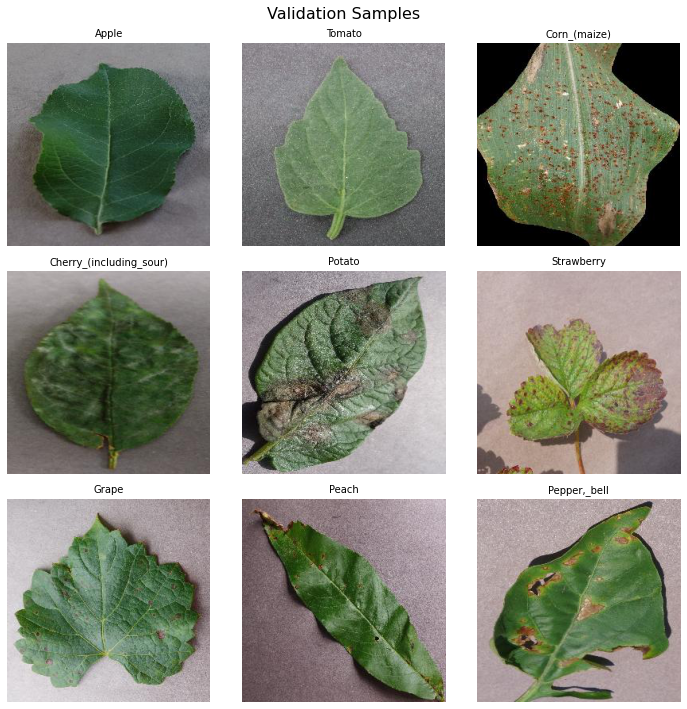

In [5]:
plot_samples_in_grid(remapped_validation_generator, new_class_indices, 9, (3, 3), "Validation Samples")

# Helping functions for Models

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def get_actual(img_path):
    for p in class_names:
        if p in img_path:
            return p
    return None
    
def Predict(model, image_path):
    image = load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = img_to_array(image) / 255.0  # Normalize pixel values
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    
    # Predict the class
    prediction = model.predict(image)
    predicted_label = class_names[np.argmax(prediction)]
    return predicted_label

In [7]:
from tqdm import tqdm
import os

def Test(model, folder_path='/kaggle/input/new-plant-diseases-dataset/test/test'):
    total, correct = 0, 0
    images = os.listdir(folder_path)
    
    for img in tqdm(images, desc="Testing Progress", unit="image"):
        img_path = os.path.join(folder_path, img)
        actual = get_actual(img_path)    
        if actual is None:
            continue
        pred = Predict(model, img_path)
        if pred == actual:
            correct += 1
        total += 1
    accuracy = correct / total if total > 0 else 0
    return accuracy


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

def Train(model, model_name, epochs):
    checkpoint_path = f'{model_name}_best_weights.h5'
    if os.path.exists(checkpoint_path):
        print(f"Loading weights from {checkpoint_path}")
        model.load_weights(checkpoint_path)

    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path, # Filepath to save the model
        monitor='val_accuracy',   # Metric to monitor
        save_best_only=True,      # Save only the model with the best validation accuracy
        mode='max',               # Maximize the monitored metric
        verbose=1,                # Print a message when saving the model
    )

    # Train the model with the checkpoint callback
    history = model.fit(
        remapped_train_generator,
        epochs=epochs,
        validation_data=remapped_validation_generator,
        steps_per_epoch=len(train_generator),  # Set the number of steps per epoch
        validation_steps=len(validation_generator),  # Set the number of validation steps
        callbacks=[checkpoint]  # Include the checkpoint callback
    )

    return history

In [9]:
def Validate(model, model_name):
    checkpoint_path = f'{model_name}_best_weights.h5'
    if os.path.exists(checkpoint_path):
        print(f"Loading weights from {checkpoint_path}")
        model.load_weights(checkpoint_path)

    loss, accuracy = model.evaluate(remapped_validation_generator,
                                steps=len(validation_generator))  # Set the number of validation steps)
    print(f"Validation Accuracy: {accuracy:.2f}")

# Models

## Manual CNN model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

custom_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),  # Conv layer
    MaxPooling2D(pool_size=(2, 2)),                                    # Pooling layer
    Conv2D(64, (3, 3), activation='relu'),                             # Conv layer
    MaxPooling2D(pool_size=(2, 2)),                                    # Pooling layer
    Flatten(),                                                         # Flatten layer
    Dense(128, activation='relu'),                                     # Fully connected layer
    Dense(9, activation='softmax')                                     # Output layer
])

custom_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
Train(custom_model, 'custom_CNN', 5)

Epoch 1/5
11/11 [==============================] - 20s 1s/step - loss: 6.8682 - accuracy: 0.2295 - val_loss: 2.0498 - val_accuracy: 0.3303

Epoch 00001: val_accuracy improved from -inf to 0.33030, saving model to custom_CNN_best_weights.h5
Epoch 2/5
11/11 [==============================] - 7s 647ms/step - loss: 1.8109 - accuracy: 0.3917 - val_loss: 1.5075 - val_accuracy: 0.4909

Epoch 00002: val_accuracy improved from 0.33030 to 0.49091, saving model to custom_CNN_best_weights.h5
Epoch 3/5
11/11 [==============================] - 7s 654ms/step - loss: 1.2305 - accuracy: 0.5780 - val_loss: 1.2144 - val_accuracy: 0.5727

Epoch 00003: val_accuracy improved from 0.49091 to 0.57273, saving model to custom_CNN_best_weights.h5
Epoch 4/5
11/11 [==============================] - 7s 655ms/step - loss: 0.7405 - accuracy: 0.7614 - val_loss: 1.0612 - val_accuracy: 0.6424

Epoch 00004: val_accuracy improved from 0.57273 to 0.64242, saving model to custom_CNN_best_weights.h5
Epoch 5/5
11/11 [========

In [12]:
Validate(custom_model, 'custom_CNN')

Loading weights from custom_CNN_best_weights.h5
3/3 [==============================] - 1s 403ms/step - loss: 0.9438 - accuracy: 0.6606
Validation Accuracy: 0.66


In [13]:
Test(custom_model)

Testing Progress: 100%|██████████| 33/33 [00:01<00:00, 21.53image/s]


0.43333333333333335

## VGG16 Model

In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Load pretrained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze the base model
base_model.trainable = False

# Add custom top layers
vgg_model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # Adjust num_classes accordingly
])

# Compile the model
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58900480/58889256 [==============================] - 0s 0us/step


In [15]:
Train(vgg_model, 'VGG16', 20)

Epoch 1/20
11/11 [==============================] - 27s 2s/step - loss: 2.1064 - accuracy: 0.2341 - val_loss: 1.9660 - val_accuracy: 0.2758

Epoch 00001: val_accuracy improved from -inf to 0.27576, saving model to VGG16_best_weights.h5
Epoch 2/20
11/11 [==============================] - 7s 704ms/step - loss: 1.8513 - accuracy: 0.3462 - val_loss: 1.7671 - val_accuracy: 0.3909

Epoch 00002: val_accuracy improved from 0.27576 to 0.39091, saving model to VGG16_best_weights.h5
Epoch 3/20
11/11 [==============================] - 7s 699ms/step - loss: 1.6792 - accuracy: 0.4288 - val_loss: 1.5791 - val_accuracy: 0.4364

Epoch 00003: val_accuracy improved from 0.39091 to 0.43636, saving model to VGG16_best_weights.h5
Epoch 4/20
11/11 [==============================] - 7s 695ms/step - loss: 1.5267 - accuracy: 0.5258 - val_loss: 1.4635 - val_accuracy: 0.4848

Epoch 00004: val_accuracy improved from 0.43636 to 0.48485, saving model to VGG16_best_weights.h5
Epoch 5/20
11/11 [=======================

In [16]:
Validate(vgg_model, 'VGG16')

Loading weights from VGG16_best_weights.h5
3/3 [==============================] - 1s 364ms/step - loss: 0.4215 - accuracy: 0.9182
Validation Accuracy: 0.92


In [17]:
Test(vgg_model)

Testing Progress: 100%|██████████| 33/33 [00:01<00:00, 17.80image/s]


0.9

## DenseNet121 Model

In [18]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Sequential

# Load pretrained DenseNet model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze the base model
base_model.trainable = False

# Add custom top layers
densenet_model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # Adjust num_classes to match your dataset
])

# Compile the model
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

29097984/29084464 [==============================] - 0s 0us/step


In [19]:
Train(densenet_model, 'DenseNet121', 10)

Epoch 1/10
11/11 [==============================] - 17s 985ms/step - loss: 1.7635 - accuracy: 0.4386 - val_loss: 1.1089 - val_accuracy: 0.6818

Epoch 00001: val_accuracy improved from -inf to 0.68182, saving model to DenseNet121_best_weights.h5
Epoch 2/10
11/11 [==============================] - 7s 678ms/step - loss: 0.8343 - accuracy: 0.7697 - val_loss: 0.5655 - val_accuracy: 0.8667

Epoch 00002: val_accuracy improved from 0.68182 to 0.86667, saving model to DenseNet121_best_weights.h5
Epoch 3/10
11/11 [==============================] - 7s 685ms/step - loss: 0.4386 - accuracy: 0.9152 - val_loss: 0.3782 - val_accuracy: 0.9242

Epoch 00003: val_accuracy improved from 0.86667 to 0.92424, saving model to DenseNet121_best_weights.h5
Epoch 4/10
11/11 [==============================] - 7s 695ms/step - loss: 0.2779 - accuracy: 0.9508 - val_loss: 0.2671 - val_accuracy: 0.9455

Epoch 00004: val_accuracy improved from 0.92424 to 0.94545, saving model to DenseNet121_best_weights.h5
Epoch 5/10
11/

In [20]:
Validate(densenet_model, 'DenseNet121')

Loading weights from DenseNet121_best_weights.h5
3/3 [==============================] - 1s 540ms/step - loss: 0.1697 - accuracy: 0.9606
Validation Accuracy: 0.96


In [37]:
Test(densenet_model)

Testing Progress: 100%|██████████| 33/33 [00:03<00:00,  9.41image/s]


0.9666666666666667

## Xception Model

In [22]:
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, Sequential

base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

for i in range(len(base_model.layers) - 27):
    base_model.layers[i].trainable = False

# Add custom top layers
Xception_model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # Adjust num_classes to match your dataset
])

# Compile the model
Xception_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

83697664/83683744 [==============================] - 0s 0us/step


In [23]:
Train(Xception_model, 'Xception', 4)

Epoch 1/4
477/477 [==============================] - 595s 1s/step - loss: 0.0525 - accuracy: 0.9841 - val_loss: 0.0194 - val_accuracy: 0.9934

Epoch 00001: val_accuracy improved from -inf to 0.99337, saving model to Xception_best_weights.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/4
477/477 [==============================] - 313s 656ms/step - loss: 0.0182 - accuracy: 0.9948 - val_loss: 0.0326 - val_accuracy: 0.9896

Epoch 00002: val_accuracy did not improve from 0.99337
Epoch 3/4
477/477 [==============================] - 304s 637ms/step - loss: 0.0170 - accuracy: 0.9947 - val_loss: 0.0832 - val_accuracy: 0.9778

Epoch 00003: val_accuracy did not improve from 0.99337
Epoch 4/4
477/477 [==============================] - 302s 633ms/step - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.0235 - val_accuracy: 0.9935

Epoch 00004: val_accuracy improved from 0.99337 to 0.99350, saving model to Xception_best_weights.h5


In [24]:
Validate(Xception_model, 'Xception')

Loading weights from Xception_best_weights.h5
119/119 [==============================] - 60s 500ms/step - loss: 0.0250 - accuracy: 0.9931
Validation Accuracy: 0.99


In [25]:
Test(Xception_model)

Testing Progress: 100%|██████████| 33/33 [00:02<00:00, 16.17image/s]


1.0